In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('./results', exist_ok=True)

with open('./brown_100.txt', 'r') as file_:
    corpus = file_.read()

def write_freqs(list_: list, filename: str) -> None:
    with open(f'./results/{filename}.txt', 'w') as file_:
        file_.write('\n'.join([' '.join(x[0]) + ' | ' + str(x[1]) for x in list_]))

## N-Gram Language Modeling
In the second assignment, you will implement an **n-gram language model** that processes input text to generate, analyze, and calculate the probabilities of sequences of `n` words (n-grams). This model will tokenize text, create n-grams, and compute their frequencies and probabilities, returning the most frequent n-grams in the text.

1. **Tokenization**: Convert the input text into a list of words (tokens).
2. **N-gram Generation**: Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers.
3. **Frequency Counting**: Count how many times each n-gram appears in the text.
4. **Probability Calculation**: Compute the probabilities of each n-gram based on its frequency and add alpha smoothing to improve generalization of items.
5. **Most Frequent N-grams**: Return the most frequent n-grams along with their probabilities, helping to identify common patterns in the text.

In [2]:
from collections import Counter, defaultdict # You may import more from collections if needed

class NGramModel:
    def __init__(self, text, n, alpha=0.0):
        """
        Initialize the NGramModel with text and the value of n.
        """
        self.text = text
        self.n = n
        self.alpha = alpha  # Alpha value for additive smoothing
        self.ngrams = {}
        self.probabilities = {}
        self.vocab = set()
        self.vocab_size = float('-inf')

    def tokenize(self) -> None:
        """
        Tokenize the text into words. 
        Fill in the code to split the text into a list of words.
        """
        tokens = []

        # split on newlines
        sentences = self.text.split('\n')

        # split on spaces, add each token to the list
        for sentence in sentences:
            tokens.extend(token.lower() for token in sentence.split())

        # set the vocab to the unique tokens
        self.vocab = set(tokens)

        return tokens

    def generate_ngrams(self, tokens: list) -> dict:
        """
        Generate n-grams from the list of tokens.
        Fill in the code to create n-grams.
        Make sure to treat each sentence independently, include the <s> and </s> tokens.

        Creates a dictionary that looks like this:
        {
            ('<s>', 'The'): #,
            ('The', 'jury'): #,
        }
        where in this case n = 2, and # is the number of times the n-gram appears in the text
        """
        self.ngrams = {}

        i = 0
        # create and count the ngrams
        while i < (len(tokens) - self.n + 1):
            # using a window of size n, create an n-gram
            ngram = tuple(tokens[i:i + self.n])

            # if this n-gram is not in the ngrams[n] dict, add it
            if ngram not in self.ngrams:
                self.ngrams[ngram] = 0

            # add this n-gram to the list of n-grams
            self.ngrams[ngram] += 1

            # if this n-gram ends with an end tag (</s>), move the window + n so we start a new sentence
            if ngram[-1] == '</s>':
                i += self.n
            # if the n-gram ends with a period and the next token is not an end tag, move the window + n so we start a new sentence
            elif ngram[-1] == '.' and tokens[i + self.n] != '</s>':
                i += self.n
            else:
                i += 1

        return self.ngrams

    def count_frequencies(self) -> None:
        """
        Count the frequencies of each n-gram.
        Fill in the code to count n-gram occurrences.
        """
        # already counted in generate_ngrams
        pass

    def calculate_probabilities(self) -> None:
        """
        Calculate probabilities of each n-gram based on its frequency. Add alpha smoothing separately. Store in self.probabilities.
        """
        self.probabilities = {}
        prefix_counts = Counter()
        if self.n > 1:
            for ngram, count in self.ngrams.items():
                prefix_counts[ngram[:-1]] += count
        
        # Get vocabulary size (unique words)
        self.vocab_size = len(self.vocab)
    
        # Calculate smoothed probability for each n-gram
        for ngram, count in self.ngrams.items():
            if self.n > 1:
                # get the prefix of the n-gram
                prefix = ngram[:-1]

                # get the count of the prefix
                prefix_count = prefix_counts[prefix]
            else:
                prefix_count = sum(self.ngrams.values())

            # Apply additive (Laplace) smoothing
            # if alpha is 0, then implicitly no smoothing is applied
            smoothed_prob = (count + self.alpha) / (prefix_count + self.alpha * self.vocab_size)
            self.probabilities[ngram] = smoothed_prob


    def most_frequent_ngrams(self, top_n: int = 10) -> list:
        """
        Return the most frequent n-grams and their probabilities.
        
        Args:
            top_n: number of most frequent n-grams to return
            
        Returns:
            list: list of tuples containing the most frequent n-grams and their probabilities
        """
        # Sort n-grams by frequency in descending order
        sorted_grams = sorted(self.ngrams.items(), key=lambda x: x[1], reverse=True)
        
        # Return top_n n-grams with their probabilities
        return [(ngram, self.probabilities[ngram]) for ngram, _ in sorted_grams[:top_n]]


    def perplexity(self, tokens) -> float:
        """
        Calculate the perplexity of the model on a given list of tokens using log space.
        
        Args:
            tokens: list of tokens to calculate perplexity on
            
        Returns:
            float: perplexity of the model on the given tokens
        """
        # we use log space to avoid underflow
        log_prob_sum = 0.0
        ngram_count = 0

        # iterate through each n-gram sequence to determine the perplexity
        for i in range(len(tokens) - self.n + 1):
            # create an ngram
            ngram = tuple(tokens[i:i + self.n])

            # skip ngrams that contain </s> or . (if it ends with </s> or ., it is okay because it is the end of a sentence)
            if '</s>' in ngram and '</s>' != ngram[-1]:
                continue
            if '.' in ngram and '.' != ngram[-1]:
                continue

            prob = self.probabilities.get(ngram)
            ngram_count += 1

            # if the ngram is not in the model, assign it a smoothed probability
            if prob is None:
                prefix_count = sum(self.ngrams.get(key) for key in self.ngrams.keys() if key[:-1] == ngram[:-1])

                # if alpha is not 0, use add-k smoothing
                if self.alpha != 0:
                    log_prob_sum += self.alpha / (prefix_count + self.alpha * self.vocab_size)
                else:
                    # otherwise, assign it a probability of 1e-10
                    log_prob_sum += np.log(1e-10)
            else:
                log_prob_sum += np.log(prob)

        return np.exp( -log_prob_sum / ngram_count) if ngram_count > 0 else float('inf')

### Unigrams

In this section, we apply the `NGramModel` to our corpus. The model can be configured to generate unigrams, bigrams, or trigrams by adjusting the value of `n`. After tokenizing the text and generating the n-grams, the model counts the occurrences of each n-gram and calculates their probabilities. The most frequent n-grams are then written to an output file.

By adjusting the n-gram size, we can analyze different levels of word dependencies in the text, providing insights into common word sequences and patterns.  

The code below will generate unigrams when the NGramModel is implemented correctly

In [3]:
n = 1  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'unigrams')
print("perplexity: ", model.perplexity(tokens))

perplexity:  258.60807994290553


### Bigrams
Bigrams allow us to explore word pairs and their relationships, providing insight into common word combinations and phrase structures within the corpus.  
The code below will generate bigrams when the NGramModel is implemented correctly.

In [4]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams')
print("perplexity: ", model.perplexity(tokens))

perplexity:  5.559044119704413


### Trigrams
Trigrams capture three-word sequences, providing a deeper understanding of longer word dependencies and commonly occurring phrases within the text.  
The code below will generate trigrams when the NGramModel is implemented correctly

In [5]:
n = 3  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'trigrams')
print("perplexity: ", model.perplexity(tokens))

perplexity:  1.3234697351446851


### Smoothing
Below, we generate **bigrams** with **smoothing** applied by setting `n = 2` and including a smoothing parameter `alpha = 1.0`. Smoothing is useful in language models to handle unseen n-grams by assigning a small probability to them. The model tokenizes the text, generates bigrams, counts their frequencies, and calculates smoothed probabilities. The most frequent bigrams are then written to an output file.





In [6]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=1.0)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams_smoothed')
print("perplexity: ", model.perplexity(tokens))

perplexity:  330.5814843763977


### Generating Text
In this example, we generate text using the **bigrams** model by providing a starting **prompt** (e.g., "the jury"). The `generate_text` function creates a sequence of words based on the trained bigram model, starting from the provided prompt and continuing based on the probabilities of the next words.

After tokenizing the corpus, generating bigrams, and calculating their frequencies and probabilities, the model uses these learned probabilities to generate text. The generated output is then written to a file.

Text generation with n-grams helps illustrate how language models can predict word sequences, allowing us to create new sentences that follow similar patterns found in the original text.

In [7]:
def generate_text(model: NGramModel, n: int, prompt: str) -> str:
    """
    Generate text using the n-gram model starting from the given prompt.
    
    Args:
        model: The trained n-gram model
        n: The size of n-grams to use
        prompt: The starting text to continue from
        
    Returns:
        A string of generated text
    """
    generated_tokens = prompt.split()
    
    max_length = len(generated_tokens) + n # Prevent infinite generation
    while len(generated_tokens) < max_length:
        # Get the last n-1 tokens as context
        context = tuple(generated_tokens[-(n-1):]) if n > 1 else tuple()
        
        # Find all possible next tokens based on the context
        possible_next = []
        for ngram, prob in model.probabilities.items():
            if ngram[:-1] == context:
                possible_next.append((ngram[-1], prob))
        
        if not possible_next:
            break  # No possible continuation
            
        # Choose next token based on probabilities
        next_token = max(possible_next, key=lambda x: x[1])[0]

        # Add the chosen token
        generated_tokens.append(next_token)
        
        # Stop if we reach a sentence end
        if next_token == '</s>':
            break
            
    return ' '.join(generated_tokens)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
generated_text = generate_text(model, 2, 'the jury')
with open(f'./results/generated_bigrams.txt', 'w') as file_:
    file_.write(generated_text)

## Word Vectors
Based on the Stanford course: https://web.stanford.edu/class/cs224n/

### Count based W2V
In this section, we use the previously trained **n-gram model** to calculate a **co-occurrence matrix**. A co-occurrence matrix shows how often words appear together within a specific context (in this case, bigrams), providing insights into word relationships in the corpus.

Steps:
1. **Tokenization and N-gram Generation**: We first tokenize the text and generate bigrams using the `NGramModel`.
2. **Vocabulary and Indexing**: The vocabulary is created from the unique tokens, and a word-to-index mapping is established.
3. **Co-occurrence Matrix**: Using the generated n-grams, we compute the co-occurrence matrix, where each entry represents how often two words occur together within the bigrams.

The co-occurrence matrix provides a numerical representation of word relationships, which is useful for tasks like word embeddings, semantic analysis, and understanding word associations.

In [8]:
# Since we already have a working ngram model, for the next part we can use the ngrams to calculate the co-occurences.
model = NGramModel(corpus, 2)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)

def create_co_matrix(ngrams: list, vocab_size: int, word_to_index: dict) -> np.ndarray:
    co_matrix = np.zeros((vocab_size, vocab_size)) # Initalize matrix
    for ngram, count in ngrams.items(): # Loop over bigrams
        if len(ngram) == 2:
            i = word_to_index[ngram[0]]
            j = word_to_index[ngram[1]]
            co_matrix[i][j] += count
    return co_matrix # Output co-occurance matrix

vocab = list(set(tokens))
vocab_size = len(vocab)

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Generate the co-occurrence matrix
co_matrix = create_co_matrix(ngrams, vocab_size, word_to_index)

# Optionally, print the matrix or parts of it
print(co_matrix) # Adapted to print out the entire co_matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


With the code below you can verify if the co-occurence works

In [9]:
def check_co_occurrence(word1, word2, co_matrix, word_to_index):
    """
    Print the co-occurrence count for a specific word pair.
    """
    if word1 not in word_to_index or word2 not in word_to_index:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")
        return

    index1 = word_to_index[word1]
    index2 = word_to_index[word2]

    co_count = co_matrix[index1][index2]
    print(f"Co-occurrence count for '{word1}' and '{word2}': {co_count}")

check_co_occurrence('the', 'jury', co_matrix, word_to_index)
check_co_occurrence('the', 'cat', co_matrix, word_to_index)

Co-occurrence count for 'the' and 'jury': 13.0
One or both words 'the' and 'cat' are not in the vocabulary.


In this part, we reduce the dimensionality of the **co-occurrence matrix** using **Singular Value Decomposition (SVD)**. This technique helps in extracting the most important features from the matrix, making it easier to visualize and interpret the relationships between words.

Steps:
1. **Singular Value Decomposition (SVD)**: The co-occurrence matrix is decomposed into three matrices: \( M = U \cdot \Sigma \cdot V^T \).
2. **Dimensionality Reduction**: We retain only the top `k` components (default is 2) from the SVD, effectively reducing the dimensionality of the matrix.
3. **Reduced Matrix**: The reduced matrix retains the most important semantic information and can be used for tasks such as **word embedding visualization** or **semantic similarity analysis**.

Dimensionality reduction allows us to capture the essence of word relationships in fewer dimensions, making it more efficient to process and visualize the data.

In [10]:
def reduce_to_k_dim(M, k=2):
    U, S, Vh = np.linalg.svd(M, full_matrices=False) # Perform SVD
    M_reduced = U[:, :k] * S[:k] # Reduce to k dimensions
    return M_reduced # Output reduced matrix

In this final part, we visualize the reduced word embeddings in **2D space**. After reducing the dimensionality of the co-occurrence matrix using SVD, we plot the embeddings for each word to observe their relationships in a low-dimensional space.

Steps:
1. **Plotting the Embeddings**: Each word from the vocabulary is plotted based on its 2D coordinates from the reduced matrix.
2. **Visualization**: The scatter plot allows us to see how words cluster together or relate to each other based on co-occurrences in the text. Words with similar contexts should appear closer to each other in the plot.
3. **Interpretation**: By looking at the 2D plot, we can analyze word similarities, relationships, and clusters formed by words that often occur together.

This visualization is a useful tool for understanding the structure of word embeddings and the relationships between words in the corpus.







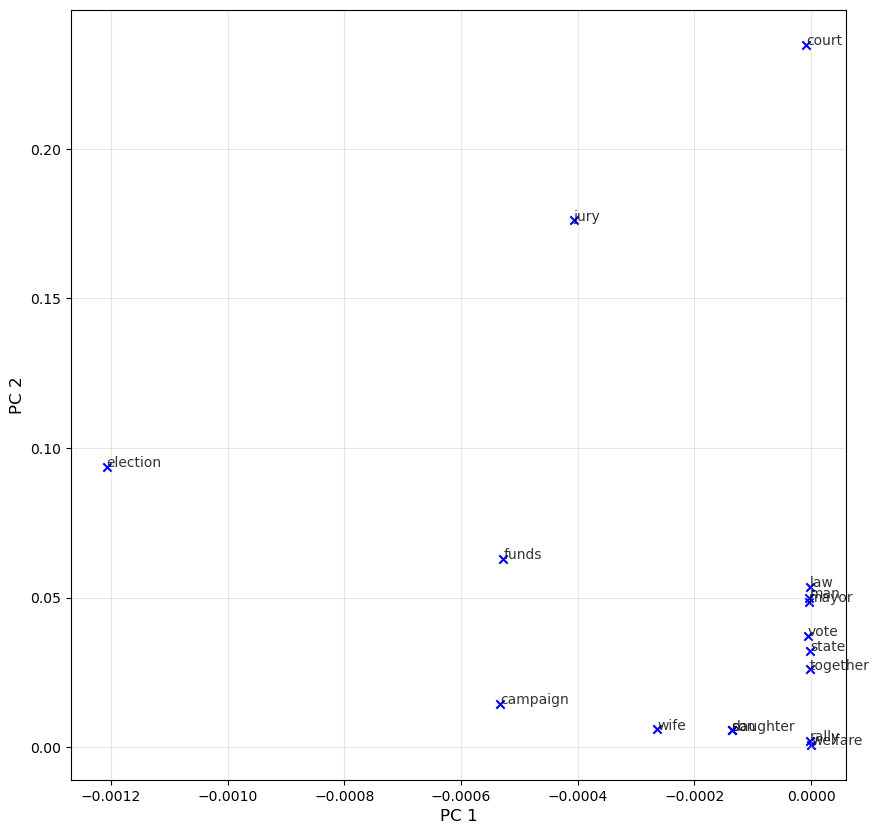

In [11]:
def plot_embeddings(M_reduced, words, word_to_index):
    plt.figure(figsize=(10, 10))
    for word in words: # Plot word embeddings based on 2D coordinates from reduced matrix
        if word in word_to_index:
            idx = word_to_index[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, marker='x', color='blue')
            plt.text(x, y, word, fontsize=10, alpha=0.8)
        else: # Notify if word is missing from vocabulary
            print(f"'{word}' missing from vocabulary")
            plt.title("Reduced Word Embeddings Visualization", fontsize=14)
    plt.xlabel("PC 1", fontsize=12)
    plt.ylabel("PC 2", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
reduced_matrix = reduce_to_k_dim(co_matrix) # Generate reduced matrix

example_words = ['jury','election','law','rally','mayor','funds','welfare','man','wife','vote','campaign','state', 'court', 'together', 'son', 'daughter'] # Selected words from brown_100 text

plot_embeddings(reduced_matrix, example_words, word_to_index)

## Prediction-Based Word Vectors
In this section, we load pre-trained word vectors using the **GloVe** embeddings from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf). The pre-trained embeddings provide rich semantic information about words based on large text corpora, allowing us to represent words as vectors that capture their meaning and relationships.

Steps:
1. **Load GloVe Word Vectors**: We use the GloVe embeddings from the `glove-wiki-gigaword-200` model, which has 200-dimensional vectors for each word.
2. **Vocabulary Matching**: We map the words from our corpus to the GloVe vocabulary and extract the corresponding vectors.
3. **Dimensionality Reduction**: After obtaining the word vectors, we reduce the dimensionality to visualize the embeddings in 2D space, allowing us to explore word relationships visually.

This is an excellent opportunity to explore how pre-trained embeddings like GloVe can be used to improve downstream NLP tasks by providing richer word representations.

In [12]:
# Do not edit
import gensim.downloader as api
import numpy as np
wv_from_bin = api.load("glove-wiki-gigaword-200")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

wv_words = list(wv_from_bin.index_to_key)
unique_tokens = set(tokens)
word2ind = {}
M = []
idx = 0
print('rendering M based on wv')
for w in wv_words:
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

print('rendering M based on unique_tokens')
for w in unique_tokens:
    if w in wv_words:
        continue
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass
M = np.stack(M)
M_reduced = reduce_to_k_dim(M, k=2)

M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

Loaded vocab size 400000
rendering M based on wv
rendering M based on unique_tokens


### Compare plots
What stands out when comparing the two different ways of embedding using the given words?

(Use this to help answer the question in your assignment document).


In both the count-based and prediction-based embedding plots, we see that there is a general relation between distance of words in the plots and semantic relationship (i.e., more closely related words tend to cluster together). However, in the count-based plot, there is a more scattered distribution across the 2 principal components, with some closely semantically related words (e.g., court, jury, election) placed far from others. In the prediction-based plot, the same words appear much more tightly clustered. Given that this plot contains the pre-trained word vectors from a large text corpora, these GloVe embeddings likely captures global word co-occurrence statistics better than the ‘brown_100’ (which only contains the first 100 sentences from the Brown corpus). Furthermore, while GloVe embeddings leverage global co-occurrence matrices, the count-based W2V models local context windows (in the form of bigrams) and therefore may not generalize as well for words that co-occur frequently in different parts of the corpus. This embedding space therefore reflects a stronger semantic relationship between words.

When comparing the two plots, it is also important to call out the effect of using normalized vectors for the prediction-based embedding plot. Here, the original magnitude (length) of vectors has been normalized to 1. Therefore, semantic similarity is captured through angles between vectors (rather than Euclidean distance in the count-based embedding plot).


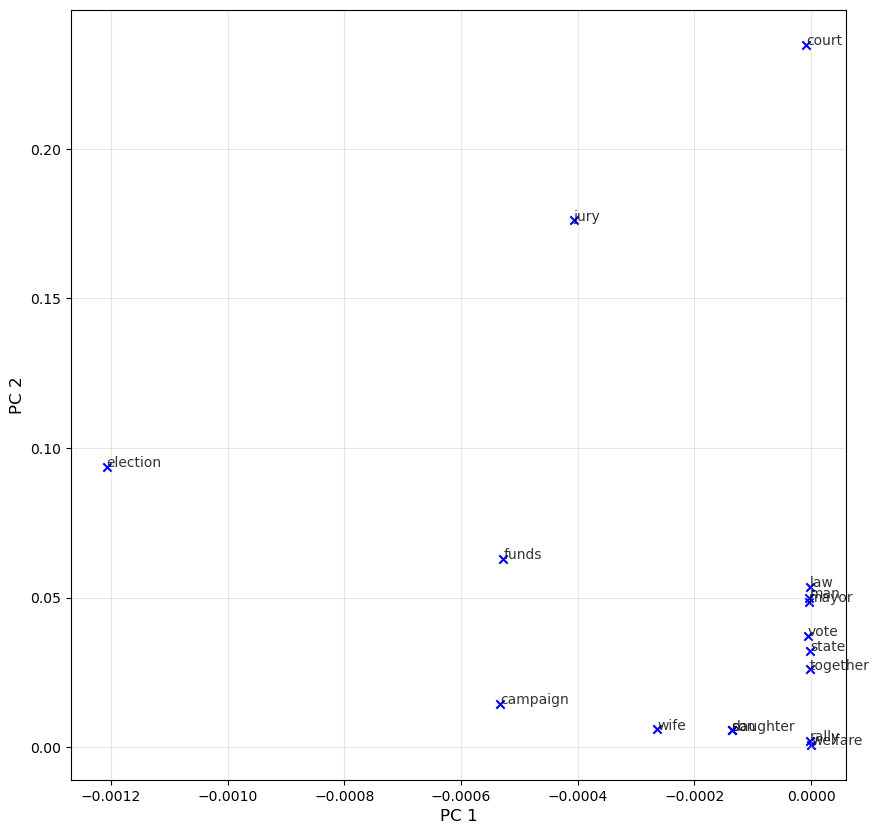

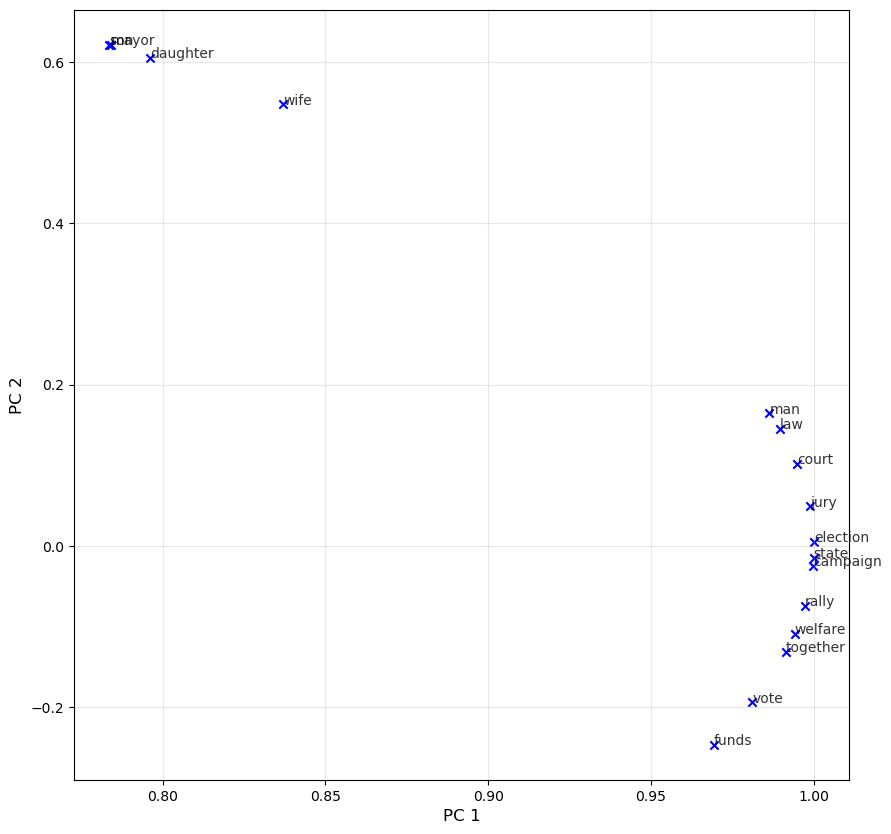

In [20]:
plot_embeddings(reduced_matrix, example_words, word_to_index) # Count-based W2V Plot
plot_embeddings(M_reduced_normalized, example_words, word2ind) # Prediction-based GloVe Plot

### Words with multiple meanings
Polysemes and homonyms are words that have more than one meaning (see [this wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms). Your task is to find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings.

For example:
- "leaves" has both the "go_away" and "a_structure_of_a_plant" meanings in the top 10.
- "scoop" has both "handed_waffle_cone" and "lowdown" meanings in the top 10.

You will probably need to try several polysemous or homonymic words before you find one.

Once you discover a word that fits this criterion, state the word and explain the multiple meanings that occur in the top 10. Reflect on why many of the polysemous or homonymic words you tried didn’t work (i.e., why the top-10 most similar words only contain one of the word's meanings).

**Note**: Use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary based on their cosine similarity to the given word. For further assistance, you can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [ ]:
print("Words similar to 'bright':")
print(wv_from_bin.most_similar("bright", topn=10))

print("Words similar to 'bow':")
print(wv_from_bin.most_similar("bow", topn=10))

From the output above, ‘bow’ has multiple meanings represented in its top 10 most similar words. One meaning relates to archery or weaponry, as seen in similar words like ‘arrow’. Another meaning of ‘bow’ refers to a physical gesture of bending the body, typically as a sign of respect or greeting. This meaning is reflected in similar words like ‘bend’ or ‘curtsy’, which may be associated with the act of lowering one’s head. A third meaning is nautical, where ‘bow’ denotes the front of a ship. This is reflected by the word ‘starboard’, a directional term used in maritime contexts.

In contrast, the word ‘bright’, meaning both ‘intelligent’ and ‘vivid in color’ only shows related terms for the latter meaning in its top 10 most similar words. Words such as colors, yellow, blue, green, pink, brighter, brightly, and light all emphasize visual brightness or illumination, while dark serves as a contrasting term. There is no indication of the ‘intelligent’ meaning (e.g., ‘the bright pupil’), suggesting that the word embedding model used is dominated by one interpretation.

This discrepancy likely highlights a broader issue in working with polysemous or homonymic words. In many cases, one sense is much more common or contextually emphasized in the training data (e.g., bright most often used in the context of lightness or color rather than intelligence), so the embedding space reflects only that dominant meaning. In contrast, ‘bow’ demonstrates more equal frequency across its primary meanings, allowing multiple interpretations to emerge clearly in its nearest neighbors.


### Synonyms
When considering **Cosine Similarity**, it's often useful to think of **Cosine Distance**, which is simply 1 - Cosine Similarity.

Find three words \( (w_1, w_2, w_3) \) where:
- \(w_1\) and \(w_2\) are **synonyms**.
- \(w_1\) and \(w_3\) are **antonyms**.

However, you need to find a case where **Cosine Distance** \( (w_1, w_3) < \text{Cosine Distance} (w_1, w_2) \). In other words, the antonym is **closer** to the word than its synonym in the vector space.

For example, "happy" (\(w_1\)) may be closer to "sad" (\(w_3\)) than to "cheerful" (\(w_2\)), which is counter-intuitive since we expect synonyms to be closer than antonyms. 

Once you find such an example, provide a possible explanation for why this result may have occurred.

Use the `wv_from_bin.distance(w1, w2)` function to compute the cosine distance between two words. You can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for further assistance.







In [15]:
print("Synonym Cosine Distance - 'cold' and 'frosty':")
print(wv_from_bin.distance("cold", "frosty"))

print("Antonym Cosine Distance - 'cold' and 'hot':")
print(wv_from_bin.distance("cold", "hot"))

Synonym Cosine Distance - 'cold' and 'frosty':
0.5487740337848663
Antonym Cosine Distance - 'cold' and 'hot':
0.40621888637542725


From the output above, the cosine distance between the synonyms ‘cold’ and ‘frosty’ is 0.5488. In comparison, the cosine distance between the antonyms ‘cold’ and ‘hot’ is 0.4062. This means that, in the underlying GloVe vector space, ‘cold’ is closer to ‘hot’ than to ‘frosty’, despite the semantic relationship in temperature suggesting the opposite.

This counterintuitive result can be explained by how word embeddings are trained. These models capture relatedness through frequency of shared contextual usage (and not direct semantic meaning). Words like ‘cold’ and ‘hot’ often appear in similar contexts (e.g., the eponymous Katy Perry classic “Hot N Cold”) because they are part of common antonymic pairs used to describe the same concepts. As a result, they develop similar distributional patterns, leading to closer vectors. On the other hand, ‘frosty’ might occur in more niche or less frequent contexts (e.g., ‘frosty morning’ or ‘frosty greeting’) that don't overlap as much with ‘cold’ (or at least not as frequently as ‘hot’), leading to a larger cosine distance despite their synonymous meaning.

### Analogies
Word vectors have demonstrated the ability to solve analogies based on their learned semantic relationships. For instance, consider the analogy: 

**"man : grandfather :: woman : x"** 

(Read: man is to grandfather as woman is to x). Using word vectors, we can find the word \(x\) that completes the analogy.

In the example provided, we use the `most_similar` function from the Gensim library. This function identifies words that are most similar to the words in the positive list and most dissimilar to those in the negative list. For analogy solving, it effectively computes:

\[ \text{word}(x) = \text{most similar to} (\text{woman} + \text{grandfather} - \text{man}) \]

The result is the word with the highest cosine similarity to the target vector. You can use this approach to explore various analogies and gain insights into the semantic structure of word vectors.

Refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for more details on the `most_similar` function and how word vectors handle analogy-solving tasks.

In [16]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
print(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793), ('granddaughter', 0.7200808525085449), ('daughter', 0.7168302536010742), ('mother', 0.7151536345481873), ('niece', 0.7005682587623596), ('father', 0.6659887433052063), ('aunt', 0.6623408794403076), ('grandson', 0.6618767976760864), ('grandparents', 0.6446609497070312), ('wife', 0.644535481929779)]


### Bias in word vectors
a. **Observation**: Consider the results of a word vector model when queried with analogies involving "man", "woman", and "profession". What are the top results returned by the model for each query?

For the query involving ‘man’ and ‘profession’, the top related words include:
‘reputation’, ‘professions’, ‘skill’, ‘skills’, ‘ethic’, ‘business’, ‘respected’, ‘practice’, ‘regarded’, and ‘life’.

For the query involving "woman" and "profession", the top related words include:
‘professions’, ‘practitioner’, ‘teaching’, ‘nursing’, ‘vocation’, ‘teacher’, ‘practicing’, ‘educator’, ‘physicians’, and ‘professionals’.

b. **Analysis**: Do you observe any gender biases in the results? For example, are certain professions more closely associated with "man" or "woman" based on the word vectors? Discuss how word embeddings might perpetuate societal biases present in the training data.

As based on the output above, I do observe a noticeable gender bias. The word vectors associate ‘woman’ more with caregiving or teaching professions (e.g., nursing, teacher, educator) and "man" more with high-status terms (e.g., reputation, skill, ethic, respected). This reflects common societal stereotypes, where women are often linked to roles in education and healthcare, while men are associated with prestige and leadership.

This pattern likely stems from biases in the training data, which may overrepresent these associations due to their frequency in news articles, books, or other texts used to train the word vector model. Since word embeddings learn from co-occurrence patterns in language, they tend to replicate and even amplify existing societal biases.

c. **Reflection**: How might such biases affect the fairness of machine learning models that use word embeddings? Suggest potential strategies for mitigating gender bias in word vector models.

As demonstrated by the gender biases reflected above, biases in word vector models can significantly impact the fairness and reliability of ML systems. For example, biased embeddings may cause automated resume filters to favor male candidates for leadership roles (detecting characteristics associated with ‘skill’ and ‘reputation’), while overlooking equally qualified female candidates. Similarly, in translation services, a language with gender agnostic pronouns may be translated to reflect historically gendered roles (e.g., “he is a CEO” vs. “she is a teacher”). Given that AI is “only as good as its data” [1], curating balanced training data that includes diverse and representative examples of men and women across a wide range of professions could help mitigate bias and word vector models. Another approach involves applying debiasing algorithms, which remove gender-related components from word vectors. For instance, the Limisiewicz et al.’s DAMA algorithm uses causal tracing to identify biased components and applies linear projections to specific layers in a model to effectively reduce gender bias without compromising overall performance [2]. Overall, removing bias in NLP systems is a complex challenge that involves not only identifying and mitigating deeply embedded societal stereotypes in training data, but also balancing fairness with the preservation of model performance.

Sources:

[1] Zou, J. (2022, January 25). Data-centric AI: AI models are only as good as their data pipeline. Stanford Institute for Human-Centered Artificial Intelligence. https://hai.stanford.edu/news/data-centric-ai-ai-models-are-only-good-their-data-pipeline

[2] Limisiewicz, T., Mareček, D., & Musil, T. (2024). Debiasing Algorithm through Model Adaptation. Proceedings of the International Conference on Learning Representations (ICLR). Retrieved from https://github.com/tomlimi/DAMA


In [17]:
print(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404), ('professions', 0.5178037881851196), ('skill', 0.49046966433525085), ('skills', 0.49005505442619324), ('ethic', 0.4897659420967102), ('business', 0.487585186958313), ('respected', 0.485920250415802), ('practice', 0.4821045696735382), ('regarded', 0.4778572618961334), ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592), ('practitioner', 0.4988412857055664), ('teaching', 0.48292139172554016), ('nursing', 0.48211804032325745), ('vocation', 0.4788965880870819), ('teacher', 0.47160351276397705), ('practicing', 0.4693780839443207), ('educator', 0.46524327993392944), ('physicians', 0.4628995656967163), ('professionals', 0.46013936400413513)]
